In [1]:
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from IPython.display import display, Markdown

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

sys.path.append(str(Path.cwd().parents[0]))
import core.preprocess as pp

# Project Definition:
## Given a list of extracted sentences from company about pages, write and deploy a machine learning classifier of your choice, that will determine whether or not the text contains descriptive content. 

## Objectives:
### We have a bag of words model as a baseline, and now we can explore some alternative models. 

1. Preprocess
2. Explore model space
3. Hyperparameter tuning
4. Validation

In [2]:
# Get data and preprocess
fname = Path.cwd().parents[0] / 'data' / 'Aboutlabeled.csv'
df = pd.read_csv(fname)
df.head()
df['Label_n'] = (pd.get_dummies(df.Label, drop_first=True, dtype=int) - 1) * -1
df = pp.preprocess(df, lemmatize_text=True, remove_stops=True)

In [3]:
X = df.TextClean
y = df.Label_n
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
tk = lambda x: x
vectorizer = TfidfVectorizer(tokenizer=tk, binary=True, stop_words=None, use_idf=True, lowercase=False, ngram_range=(1,2))

features_train = vectorizer.fit_transform(X_train)
features_test = vectorizer.transform(X_test)

#Fix class imbalance
smote = SMOTE(random_state = 101)
X, y = smote.fit_resample(features_train, y_train)


In [55]:
# Logistic Regression
LR = LogisticRegression(max_iter=1000, solver='lbfgs', penalty='l2')
LR.fit(X,y.ravel())
train_prob_lr = LR.predict_proba(X)[:, 1]
train_predictions_lr = LR.predict(X)
test_prob_lr = LR.predict_proba(features_test)[:, 1]
test_predictions_lr = LR.predict(features_test)
print(classification_report(y_test, test_predictions_lr))

# Random Forest
RF = RandomForestClassifier(n_estimators=100, max_features = 'sqrt')
RF.fit(X,y.ravel())
train_prob_rf = RF.predict_proba(X)[:, 1]
train_predictions_rf = RF.predict(X)
test_prob_rf = RF.predict_proba(features_test)[:, 1]
test_predictions_rf = RF.predict(features_test)
print(classification_report(y_test, test_predictions_rf))

# KNN
KN = KNeighborsClassifier(n_neighbors=50, metric='cosine')
KN.fit(X,y.ravel())
train_prob_kn = KN.predict_proba(X)[:, 1]
train_predictions_KN = KN.predict(X)
test_prob_kn = KN.predict_proba(features_test)[:, 1]
test_predictions_kn = KN.predict(features_test)
print(classification_report(y_test, test_predictions_kn))




              precision    recall  f1-score   support

           0       0.96      0.86      0.91      3684
           1       0.39      0.71      0.51       479

    accuracy                           0.84      4163
   macro avg       0.68      0.78      0.71      4163
weighted avg       0.89      0.84      0.86      4163

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      3684
           1       0.82      0.06      0.11       479

    accuracy                           0.89      4163
   macro avg       0.85      0.53      0.52      4163
weighted avg       0.88      0.89      0.85      4163

              precision    recall  f1-score   support

           0       0.93      0.71      0.81      3684
           1       0.20      0.57      0.30       479

    accuracy                           0.70      4163
   macro avg       0.57      0.64      0.55      4163
weighted avg       0.84      0.70      0.75      4163



Text(0.5, 1.0, 'KNN')

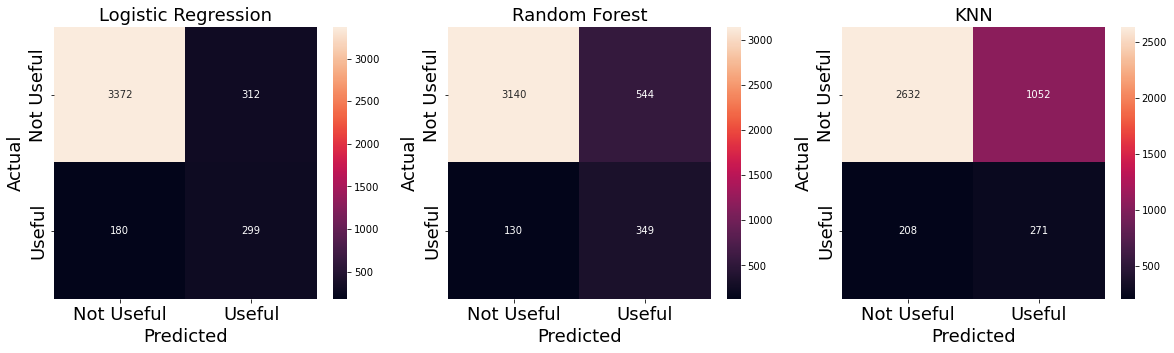

In [45]:
cm_lr = confusion_matrix(y_test, test_predictions_lr, normalize=None)
cm_rf = confusion_matrix(y_test, test_predictions_rf, normalize=None)
cm_kn = confusion_matrix(y_test, test_predictions_kn, normalize=None)

plt.figure(figsize=[20,5])
plt.subplot(131)
sns.heatmap(cm_lr, annot=True, fmt='d')
plt.xlabel('Predicted',fontsize=18)
plt.ylabel('Actual',fontsize=18)
plt.xticks([.5,1.5],labels=['Not Useful','Useful'],fontsize=18)
plt.yticks([0.5,1.5],labels=['Not Useful','Useful'],fontsize=18,va="center")
plt.title('Logistic Regression', fontsize = 18)

plt.subplot(132)
sns.heatmap(cm_rf, annot=True, fmt='d')
plt.xlabel('Predicted',fontsize=18)
plt.ylabel('Actual',fontsize=18)
plt.xticks([.5,1.5],labels=['Not Useful','Useful'],fontsize=18)
plt.yticks([0.5,1.5],labels=['Not Useful','Useful'],fontsize=18,va="center")
plt.title('Random Forest', fontsize = 18)

plt.subplot(133)
sns.heatmap(cm_kn, annot=True, fmt='d')
plt.xlabel('Predicted',fontsize=18)
plt.ylabel('Actual',fontsize=18)
plt.xticks([.5,1.5],labels=['Not Useful','Useful'],fontsize=18)
plt.yticks([0.5,1.5],labels=['Not Useful','Useful'],fontsize=18,va="center")
plt.title('KNN', fontsize = 18 )

In [46]:
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
lr_fpr, lr_tpr, _ = roc_curve(y_test, test_prob_lr)
rf_fpr, rf_tpr, _ = roc_curve(y_test, test_prob_rf)
kn_fpr, kn_tpr, _ = roc_curve(y_test, test_prob_kn)



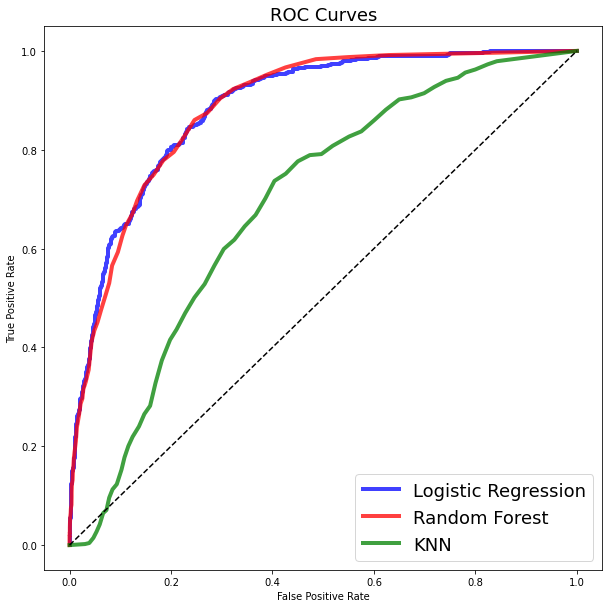

In [47]:
plt.figure(figsize=[10,10])
plt.plot(lr_fpr, lr_tpr, 'b', lw = 4, alpha = .75)
plt.plot(rf_fpr, rf_tpr, 'r', lw = 4, alpha = .75)
plt.plot(kn_fpr, kn_tpr, 'g', lw = 4, alpha = .75)
plt.plot(base_fpr, base_tpr, 'k', ls = '--')
plt.legend(['Logistic Regression', 'Random Forest', 'KNN'], fontsize=18)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves', fontsize=18);

**Observations**: The KNN performs quite poorly, while the LR and RF classifiers are quite similar. Using a default threshold, it appears as if the RF classifier is much worse, so we will likely need to tune that. For now, let's proceed with the LR and RF models for hyperparameter tuning. 

In [34]:
clf = LogisticRegression(max_iter=500)

grid_values = {'solver':['liblinear','lbfgs','newton-cg','saga'],
               'penalty': ['l1', 'l2','elasticnet'], 
               'C':[0.001, .009, 0.01, .09, 1, 5, 10, 25]}

grid_clf_acc = GridSearchCV(clf, param_grid=grid_values, scoring='roc_auc')
grid_clf_acc.fit(X, y)

#Predict values based on new parameters
y_pred_acc = grid_clf_acc.predict(features_test)




/Users/brandon/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brandon/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/brandon/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/brandon/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/brando

Accuracy Score : 0.8815757866922892
Precision Score : 0.48856209150326796
Recall Score : 0.6242171189979123
F1 Score : 0.5481209899175068


array([[3371,  313],
       [ 180,  299]])

In [36]:
# New Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)

Accuracy Score : 0.8815757866922892
Precision Score : 0.48856209150326796
Recall Score : 0.6242171189979123
F1 Score : 0.5481209899175068


array([[3371,  313],
       [ 180,  299]])

In [49]:
LR_tuned = LogisticRegression(max_iter=1000, solver='saga', penalty='l2', C=25)
LR_tuned.fit(X,y.ravel())
train_prob_lr_tined = LR.predict_proba(X)[:, 1]
train_predictions_lr_tuned = LR.predict(X)
test_prob_lr_tuned = LR.predict_proba(features_test)[:, 1]
test_predictions_lr_tuned = LR.predict(features_test)
print(classification_report(y_test, test_predictions_lr_tuned))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      3684
           1       0.49      0.62      0.55       479

    accuracy                           0.88      4163
   macro avg       0.72      0.77      0.74      4163
weighted avg       0.90      0.88      0.89      4163



Text(0.5, 1.0, 'Logistic Regression')

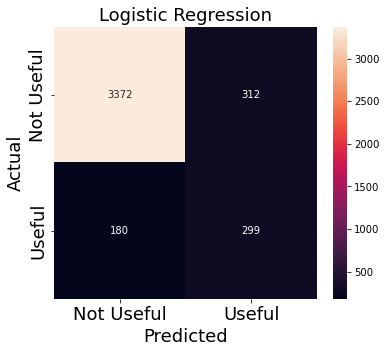

In [50]:
cm_lr_tuned = confusion_matrix(y_test, test_predictions_lr_tuned, normalize=None)


plt.figure(figsize=[20,5])
plt.subplot(131)
sns.heatmap(cm_lr, annot=True, fmt='d')
plt.xlabel('Predicted',fontsize=18)
plt.ylabel('Actual',fontsize=18)
plt.xticks([.5,1.5],labels=['Not Useful','Useful'],fontsize=18)
plt.yticks([0.5,1.5],labels=['Not Useful','Useful'],fontsize=18,va="center")
plt.title('Logistic Regression', fontsize = 18)


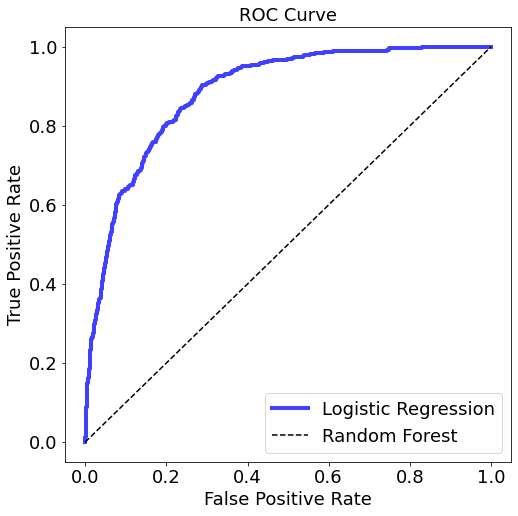

In [54]:
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
lr_fpr_tuned, lr_tpr_tuned, _ = roc_curve(y_test, test_prob_lr_tuned)

plt.figure(figsize=[8,8])
plt.plot(lr_fpr, lr_tpr, 'b', lw = 4, alpha = .75)
plt.plot(base_fpr, base_tpr, 'k', ls = '--')
plt.legend(['Logistic Regression', 'Random Forest', 'KNN'], fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18); plt.ylabel('True Positive Rate', fontsize=18); plt.title('ROC Curve', fontsize=18)
plt.ylabel
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);

In [ ]:
cpk.dump()